In [1]:
import numpy as np 
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime

In [3]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)

(108, 218, 61)


In [85]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(U, X, seed=42):  
    K, N, T = X.shape
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 100  
    key = random.PRNGKey(seed)
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (K**2) ) * jnp.sum(batched_loss)
    return -S

grad_loss = grad(loss)

def update_U(U, X, optimizer, opt_state):
    dL_dU = grad_loss(U, X)
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, U)
    U_updated = optax.apply_updates(U, updates)
    return U_updated, opt_state_updated

def optimize_U(X, iterations=5000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    U = random.normal(key, (N, d))

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(U)
    
    ls_fun = []

    for i in range(iterations):
        U, opt_state = update_U(U, X, optimizer, opt_state)
        ls_fun.append(loss(U, X))
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(U, X)}")
    
    return U, ls_fun

optimized_U = optimize_U(X)                     #optimized_U (N,d)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')
file_name = 'optimized_U_' + date_time_str
np.save(file_name, optimized_U[0])

Iteration 0, S: -955168.125
Iteration 10, S: 5661060.0
Iteration 20, S: 12354412.0
Iteration 30, S: 21456922.0
Iteration 40, S: 34870884.0
Iteration 50, S: 54885308.0
Iteration 60, S: 84477384.0
Iteration 70, S: 127437312.0
Iteration 80, S: 188408976.0
Iteration 90, S: 272877024.0
Iteration 100, S: 387152000.0
Iteration 110, S: 538341376.0
Iteration 120, S: -1183042304.0
Iteration 130, S: 658412992.0
Iteration 140, S: 633694976.0
Iteration 150, S: 601826368.0
Iteration 160, S: 584580480.0
Iteration 170, S: -830428608.0
Iteration 180, S: -795068928.0
Iteration 190, S: -761491456.0
Iteration 200, S: -729423744.0
Iteration 210, S: -695257984.0
Iteration 220, S: 489252864.0
Iteration 230, S: 477348576.0
Iteration 240, S: -619095232.0
Iteration 250, S: 453148544.0
Iteration 260, S: -573769728.0
Iteration 270, S: -553107840.0
Iteration 280, S: 422431296.0
Iteration 290, S: -514140928.0
Iteration 300, S: -497011040.0
Iteration 310, S: -479732608.0
Iteration 320, S: 386844544.0
Iteration 330, 

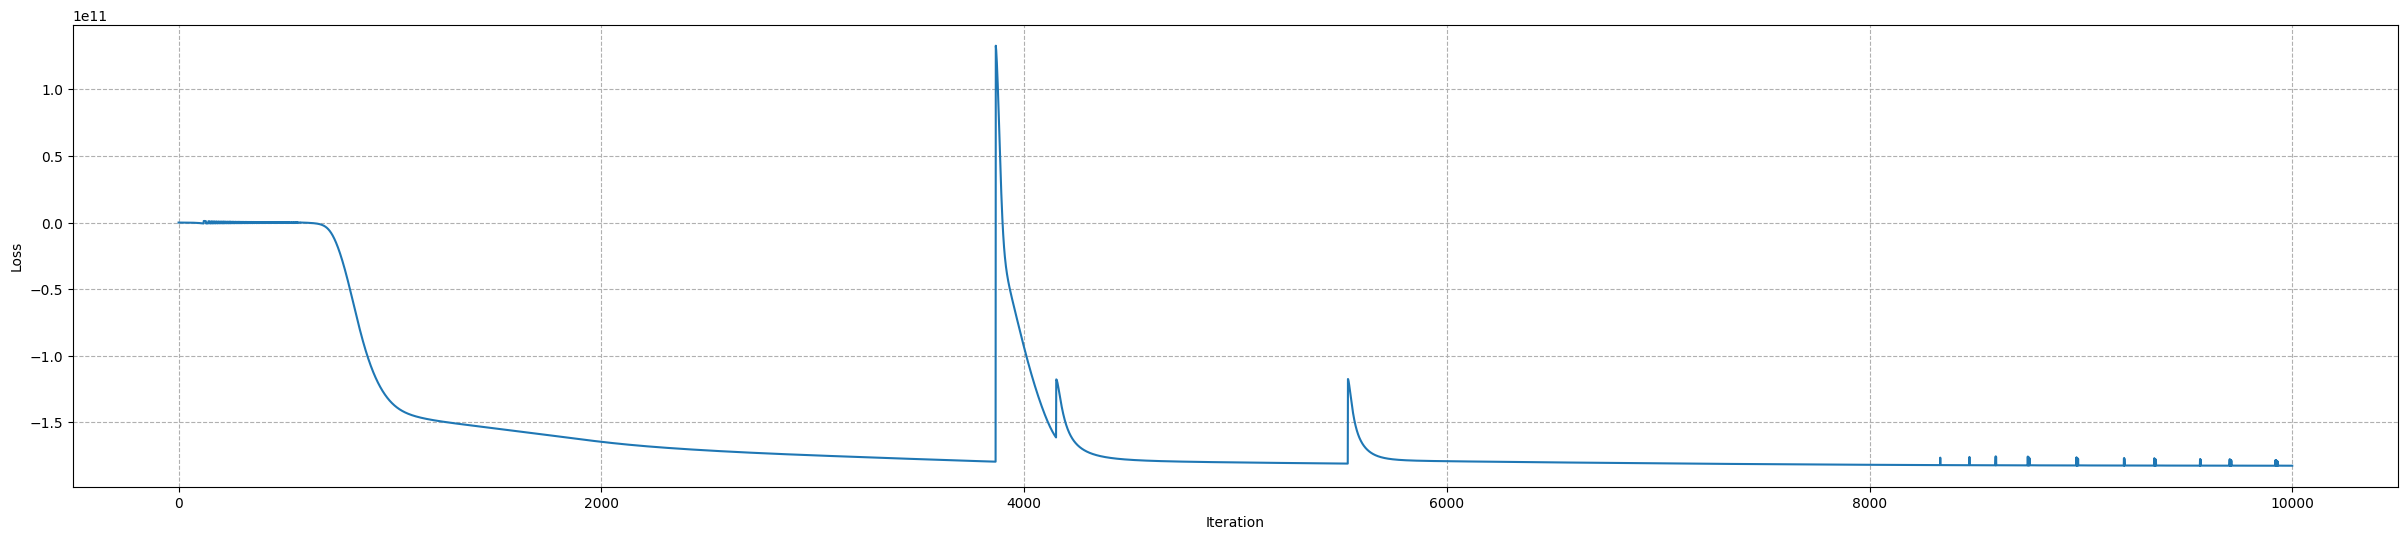

In [92]:
plt.figure(figsize=(30, 6))
plt.plot(optimized_U[1])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 


In [4]:
optimized_U = np.load('optimized_U_10000.npy')

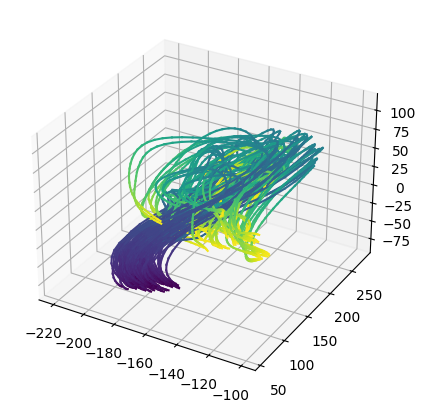

In [6]:
optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)        #optimized_U_tilde = optimized_U #[0]
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde, X)    

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)  #[1,2,3,4,-1,-2,-3,-4]

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))

# def make_frame(angle):
#     ax.view_init(30, angle)
#     fig.canvas.draw() 
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     return image

# angles = range(0, 360, 2) 
# frames = [make_frame(angle) for angle in angles]

# gif_path = "trajectories_rotation_test.gif"
# imageio.mimsave(gif_path, frames, fps=20)

# gif_path
